In [4]:
import os
import time
from collections import OrderedDict
from joblib import dump, load

import numpy as np
from scipy.misc import imread, imsave, imresize

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

import theano.tensor as T
import lasagne.layers
import theano

from nn_utils import build_UNet, iterate_minibatches

from joblib import load

In [2]:
run processing_functions.ipynb

In [ ]:
patch_size = 64
base_n_filters = 32
learning_rate = 1e-3
import lasagne.nonlinearities 
nonlinearity = lasagne.nonlinearities.elu
num_epochs = 10
batch_size = 128

In [70]:
learned_stack_name = 'Kamchatka_basalt+ceramics'
weights_name = ''.join([learned_stack_name, '_weights/UNet_params_ep009.jbl'])

In [71]:
input_image = T.tensor4('input')
target = T.matrix('output', dtype='int64')

net = build_UNet(n_input_channels=1, BATCH_SIZE=None, num_output_classes=2,
                 pad='same', nonlinearity=lasagne.nonlinearities.elu,
                 input_dim=(patch_size, patch_size), base_n_filters=base_n_filters, do_dropout=True,
                 weights=load(weights_name))
predictions = lasagne.layers.get_output(net['output_flattened'], input_image)
get_predictions = theano.function([input_image], predictions)

In [72]:
try:
    os.mkdir('results/' + learned_stack_name) 
except OSError:
    pass

In [303]:
path_to_data = '/home/efim/study/10 semester/course work/all_data/binary_data'
stack_name = 'Urna_30'
fname = 'stackkrig0499.bmp'

In [304]:
path_X = os.path.join(path_to_data, stack_name, 'NLM', fname)
path_Y = os.path.join(path_to_data, stack_name, 'CAC', fname)

In [305]:
img = imread(path_X)
label = imread(path_Y)

In [306]:
%%time
prediction = predict_image(img, get_predictions, patch_size, n_input_channels=1)    

CPU times: user 40.4 s, sys: 29.9 s, total: 1min 10s
Wall time: 18 s


In [307]:
prediction_thresh = np.where(prediction > 0.01, np.ones_like(label), np.zeros_like(label))

In [308]:
label_float = label.astype(np.float32) / 255

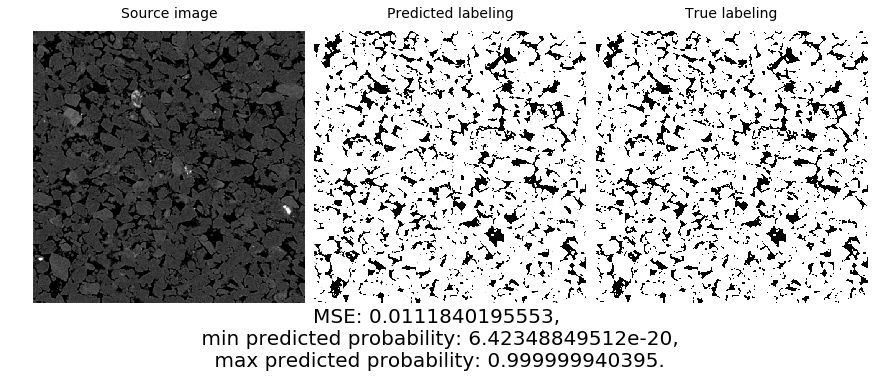

In [309]:
fig = plt.figure(figsize=(15,5))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.025, hspace=0.05)

ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax2.axis('off')
ax2.imshow(prediction, cmap='gray')
ax3.axis('off')
ax3.imshow(label, cmap='gray')

ax1.text(0.5, 1.05, "Source image", size=14, ha="center", 
         transform=ax1.transAxes)
ax2.text(0.5, 1.05, "Predicted labeling", size=14, ha="center", 
         transform=ax2.transAxes)
ax3.text(0.5, 1.05, "True labeling", size=14, ha="center", 
         transform=ax3.transAxes)
MSE = ((label_float - prediction) ** 2).sum() / label.shape[0] / label.shape[1]
minp = prediction.min()
maxp = prediction.max()
s = 'MSE: {},\n min predicted probability: {},\n max predicted probability: {}.'.format(MSE, minp, maxp)
fig.text(0.5, -0.05, s, size=20, ha='center')
plt.savefig('results/' + learned_stack_name + '/' + stack_name + '_' + fname.split('.')[0] + '.jpg')
plt.show()

In [49]:
def plot_metric(fname, metric_name):
    results = load('../output_data/' + fname + '.jbl')
    plt.figure(figsize=(10, 10))
    for k, v in results.items():
        x, y = v[metric_name]
        plt.plot(x, y, label=k)
    plt.legend(loc='best', fontsize=16)
    plt.xlim([0, 1])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(fname, fontsize=24)
    plt.xlabel('Threshold', fontsize=22)
    plt.ylabel(metric_name[0].upper() + metric_name[1:], fontsize=22)
    plt.savefig('../output_data/' + fname + '-' + metric_name + '.jpg')
    plt.show()

In [36]:
fname = 'carb96558_Urna_22'

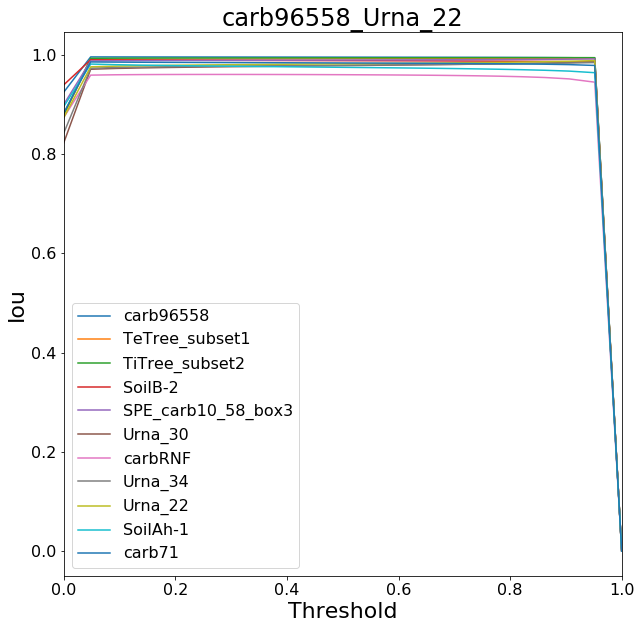

In [53]:
plot_metric(fname, 'iou')